length=463
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 10s 40ms/step - loss: 0.1394 - val_loss: 0.1015
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 8s 30ms/step - loss: 0.1068 - val_loss: 0.1139
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 8s 31ms/step - loss: 0.1035 - val_loss: 0.0874
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 7s 28ms/step - loss: 0.1009 - val_loss: 0.1009
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 7s 28ms/step - loss: 0.1026 - val_loss: 0.1014
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 7s 28ms/step - loss: 0.1045 - val_loss: 0.1045
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 7s 28ms/step - loss:

Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 7s 29ms/step - loss: 0.0419 - val_loss: 0.0415
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 7s 29ms/step - loss: 0.0442 - val_loss: 0.0443
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 7s 29ms/step - loss: 0.0403 - val_loss: 0.0401
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 7s 29ms/step - loss: 0.0404 - val_loss: 0.0413
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 7s 29ms/step - loss: 0.0412 - val_loss: 0.0392
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 8s 29ms/step - loss: 0.0415 - val_loss: 0.0405
Train on 260 samples, validate on 10 samples
Epoch 1/1
260/260 [==============================] - 7s 29ms/step - loss: 0.0395 - va

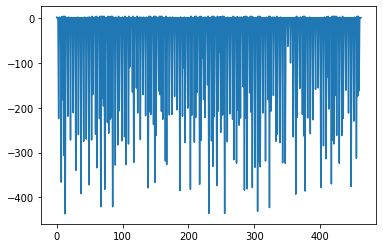

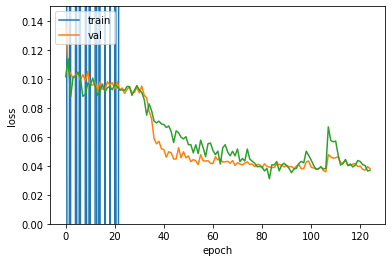

Train Score:  0.032506975992889695
Validataion Score:  0.03698545723618736
Test Score:  0.03936459525025384
saved model as 401060E0.h5
query=SELECT *from sensors  where user = 401060 and user2 = 0 and type = 'E'  and time >= '2019-6-20' and time <= '2019-7-20'  order by time, id 
Train Score: 0.032507
Validation Score: 0.036985
Test Score: 0.039365
Saved model 401060E0.h5


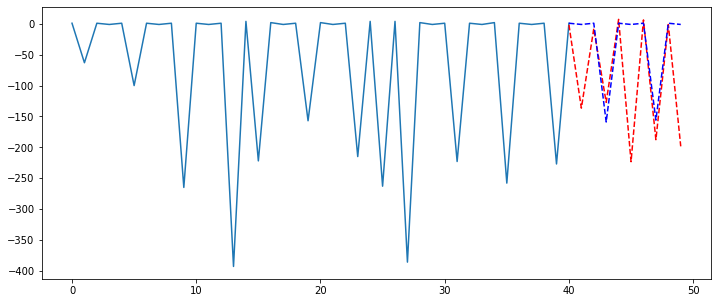

In [8]:
# %load learn.py
#!/usr/bin/env python

# In[1]:


# 0. 사용할 패키지 불러오기
import pandas as pd 
import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import mysql.connector
%matplotlib inline

loop = 125
look_ahead = 10
look_back = 40
ret = ""

signal_data = ""
predictions  = ""
measured_data = ""


def translate(level):
    # Trim zero leader and trailer
    i = 0
    while not level[i]: i += 1
    j = len(level-1)
    while not level[i]: j -= 1
    level = level[i:j-1]    

    seq = []
    old = 1    # begin with 1
    c = 0

    for x in level:
        if x != old:
            if old > 0: seq.append(c)
            else: seq.append(c * -1)
            c = 1
        else:
            c += 1
        old = x
    print("length=%d"%len(seq))
    return np.array(seq)

def read_data(user, type, user2, frm, to):
    global X
    global level
    query = ("SELECT *from sensors "
             " where user = %s and user2 = %s and type = '%s' "
             " and time >= '%s' and time <= '%s' "
             " order by time, id "%(user,user2, type, frm, to))
    global ret
    ret += "query=%s"%query
    cnx = mysql.connector.connect(
        host="sensor.c2rirrernrhc.ap-northeast-2.rds.amazonaws.com",
        database="connware",
        user="sensor",
        passwd="sensor.Ann8#"
    )
    d = pd.read_sql(query, con=cnx)
    if len(d) < 1600:
        print("data < 1600")
    
    npd = np.array(d['value'])
    X = npd.reshape(len(d), 1)
    level = KMeans(n_clusters=2).fit_predict(X)

    v0 = -1
    v1 = -1
    for i in range(len(level)):
        if v0 == -1 and not level[i]: v0 = d['value'][i]
        if v1 == -1 and level[i]: v1 = d['value'][i]
        if v1 != -1 and v0 != -1: break

    if v0 > v1:
        print("switch label")
        for i in range(len(level)):
            if level[i]: level[i] = 0
            else: level[i] = 1    
    
    seq = translate(level)
    return seq[:,None]

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data)-look_back):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

def learn(user, type, user2, frm, to):
    global signal_data, measured_data, predictions
    # 1. 데이터셋 생성하기
    signal_data = read_data(user, type, user2, frm, to)
    plt.plot(signal_data)
    
    
    # In[2]:
    
    plt.figure()
    plt.plot(signal_data[-23:])
    
    
    # In[3]:
    
    
    # 데이터 전처리
    scaler = MinMaxScaler(feature_range=(0, 1))
    signal_data = scaler.fit_transform(signal_data)
    
    # 데이터 분리
    train = signal_data[0:300]
    val = signal_data[300:350]
    test = signal_data[350:400]
    
    # 데이터셋 생성
    x_train, y_train = create_dataset(train, look_back)
    x_val, y_val = create_dataset(val, look_back)
    x_test, y_test = create_dataset(test, look_back)
    
    # 데이터셋 전처리
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    # 2. 모델 구성하기
    model = Sequential()
    for i in range(2):
        model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
        model.add(Dropout(0.3))
    model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    
    # 3. 모델 학습과정 설정하기
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # 4. 모델 학습시키기
    custom_hist = CustomHistory()
    custom_hist.init()
      
    for i in range(loop):
        model.fit(x_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val, y_val))
        model.reset_states()
    
    # 5. 학습과정 살펴보기
    plt.plot(custom_hist.train_loss)
    plt.plot(custom_hist.val_loss)
    plt.ylim(0.0, 0.15)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # 6. 모델 평가하기
    trainScore = model.evaluate(x_train, y_train, batch_size=1, verbose=0)
    model.reset_states()
    print('Train Score: ', trainScore)
    global ret
    ret += "\nTrain Score: %f"%trainScore
    valScore = model.evaluate(x_val, y_val, batch_size=1, verbose=0)
    model.reset_states()
    print('Validataion Score: ', valScore)
    ret += "\nValidation Score: %f"%valScore
    testScore = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
    model.reset_states()
    print('Test Score: ', testScore)
    ret += "\nTest Score: %f"%testScore
    
    # 데이터셋 전처리
    signal_data = test
    xhat = signal_data[-look_back-look_ahead:-look_ahead]
    measured_data = signal_data[-look_ahead:]
    predictions = np.zeros((look_ahead,1))
  

    for i in range(look_ahead):
        prediction = model.predict(np.array([xhat]), batch_size=1)
        predictions[i] = prediction
        xhat = np.vstack([xhat[1:],prediction])
       
    plt.figure(figsize=(12,5))
    plt.plot(np.arange(0,look_back+1), scaler.inverse_transform(signal_data[-look_back-look_ahead:-look_ahead+1]))
    plt.plot(np.arange(look_back,look_back+look_ahead), scaler.inverse_transform(predictions),'r', linestyle='dashed', label="prediction")
    plt.plot(np.arange(look_back,look_back+look_ahead), scaler.inverse_transform(measured_data),'b',linestyle='dashed', label="measured")
    
    
    fname = "%s%s%s.h5"%(user, type, user2)
    model.save(fname)
    print("saved model as %s"%fname)
    ret += "\nSaved model %s"%fname
    joblib.dump(scaler, "%s%s%s.joblib"%(user, type, user2))
    return ret

if __name__ == "__main__":
    # execute only if run as a script
    user = '401060'
    type = 'E'
    user2 = '0'
    frm = '2019-6-20'
    to = '2019-7-20'
    # evaluate('401021', 'E', '0', '2019-7-21 12:00')
    ret = ""
    ret = learn(user, type, user2, frm, to)
    print(ret)